In [5]:
# conda install -c conda-forge segmentation-models-pytorch

In [1]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import torch
from torchinfo import summary
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms as T
import os
from PIL import Image
import numpy as np

/home/a.smith3/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = smp.Unet('resnet34', classes=3, activation='softmax').to(device)

In [5]:
summary(model)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─ResNetEncoder: 1-1                          --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    │    └─BasicBlock: 3-3                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   230,144
│    │    └─BasicBlock: 3-5                   295,424
│    │    └─BasicBlock: 3-6                   295,424
│    │    └─BasicBlock: 3-7                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   919,040
│    │    └─BasicBlock: 3-9                   1,180,672
│    │    └─Basi

In [6]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [7]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters()},
    {'params': model.segmentation_head.parameters()}
], lr=1e-4)

In [8]:
mask_dir = os.path.join(os.getcwd(),"labels/final_labels")
image_dir= os.path.join(os.getcwd(),"images_224_rename")

In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir,
                 transform=None, mask_transform=None):

        self.image_dir      = image_dir
        self.mask_dir       = mask_dir
        self.transform      = transform
        self.mask_transform = mask_transform

        # *** keep only mask files that really exist and match a .jpg ***
        self.image_filenames = sorted([
            f for f in os.listdir(mask_dir)
            if f.endswith(".png")                                  # only masks
            and os.path.isfile(os.path.join(mask_dir, f))          # skip dirs
            and os.path.isfile(os.path.join(image_dir,
                                            f.replace(".png", ".jpg")))  # paired img
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        mask_name  = self.image_filenames[idx]            # e.g. 001.png
        img_name   = mask_name.replace(".png", ".jpg")     # e.g. 001.jpg

        img_path   = os.path.join(self.image_dir, img_name)
        mask_path  = os.path.join(self.mask_dir,  mask_name)

        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")         # 1‑channel

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


In [10]:
image_transform = T.Compose([
    T.ToTensor(),  # [0,1] 
    T.Normalize(mean=[0.485, 0.456, 0.406],  
                std=[0.229, 0.224, 0.225])
])

In [11]:
# turn mask to tensor
mask_transform = T.Compose([
    T.PILToTensor(),
    T.Lambda(lambda x: x.squeeze().long())
])


In [12]:
# build Dataset
dataset = SegmentationDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    mask_transform = mask_transform
)

In [13]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [14]:
for imgs, masks in dataloader:
    print(imgs.shape, masks.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])
torch.Size([10, 3, 224, 224]) torch.Size([10, 224, 224])


In [15]:
def pixel_accuracy(preds, masks):
    """
    preds: prediction, shape = (B, H, W)
    masks: ground truth mask，shape = (B, H, W)
    """
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc

In [16]:
model.train()
for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.long().squeeze(1).to(device)  

        outputs = model(imgs)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        val_loss = 0
        val_acc = 0
        val_batches = 0
    
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.long().squeeze(1).to(device)
            
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            loss = loss_fn(outputs, masks)
            acc = pixel_accuracy(preds, masks)
    
            val_loss += loss.item()
            val_acc += acc.item()
            val_batches += 1
    
        avg_loss = val_loss / val_batches
        avg_acc = val_acc / val_batches
        print(f"Epoch [{epoch+1}], Accuracy: {avg_acc:.4f}, Loss: {avg_loss:.4f}")

/home/a.smith3/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1], Accuracy: 0.1455, Loss: 1.1441
Epoch [2], Accuracy: 0.2174, Loss: 1.1662
Epoch [3], Accuracy: 0.4390, Loss: 1.0765
Epoch [4], Accuracy: 0.6304, Loss: 0.9765
Epoch [5], Accuracy: 0.7679, Loss: 0.9083
Epoch [6], Accuracy: 0.8577, Loss: 0.8615
Epoch [7], Accuracy: 0.9133, Loss: 0.8288
Epoch [8], Accuracy: 0.9411, Loss: 0.8068
Epoch [9], Accuracy: 0.9576, Loss: 0.7918
Epoch [10], Accuracy: 0.9712, Loss: 0.7790


In [17]:
from torchvision.utils import save_image

In [18]:
def save_file(idx):
    model.eval()
    save_dir = os.path.join(os.getcwd(),"labels/prediction")
    os.makedirs(save_dir, exist_ok=True)
    

    idx = idx 
    image, mask = dataset[idx]
    filename = dataset.image_filenames[idx]
    
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1) 

    pred_np = pred.squeeze().cpu().numpy().astype(np.uint8)
    pred_img = Image.fromarray(pred_np, mode='L')  
    
    # save path
    save_path = os.path.join(save_dir, filename)
    pred_img.save(save_path)


In [19]:
# save_file(0)

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

def visualize_simple(image, pred_mask, true_mask, class_colors):
    """
    Visualize the original image, prediction, and ground truth using Matplotlib

    Args:
        image (Tensor): Original image (C, H, W)
        pred_mask (Tensor): Prediction mask (H, W)
        true_mask (Tensor): Ground truth mask (H, W)
        class_colors (dict): RGB colors for each class
    """
    # Convert to numpy arrays
    image_np = TF.to_pil_image(image.cpu()).convert("RGB")
    pred_np = pred_mask.squeeze().cpu().numpy()
    true_np = true_mask.squeeze().cpu().numpy()

    # Map to color images
    pred_colored = mask_to_color(pred_np, class_colors)
    true_colored = mask_to_color(true_np, class_colors)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(true_colored)
    plt.title("Ground Truth")
    plt.axis("off")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred_colored)
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def mask_to_color(mask, class_colors):
    """
    Convert a mask (H, W) to a color image using the provided class_colors

    Args:
        mask (ndarray): Mask (H, W)
        class_colors (dict): RGB colors for each class
    """
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

In [21]:
def showCompare(index):
    image, label = dataset[index]
    image = image.to(device).unsqueeze(0)
    
    # predict
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1)
    
    # define class color
    class_colors = {
        0: (0, 0, 0),       # background - black
        1: (255, 0, 0),     # pathogen - red
        2: (0, 255, 0),     # petri dish - green
    }
    
    # visualize
    visualize_simple(image.squeeze(0), pred.squeeze(0), label, class_colors)


/home/a.smith3/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


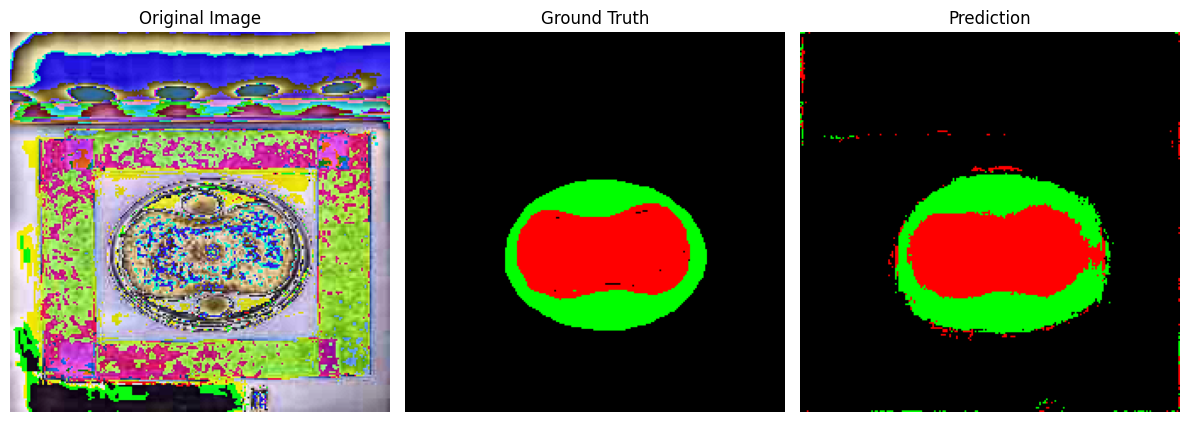

The original image looks weird because it has been normalized


In [22]:
showCompare(33)
print("The original image looks weird because it has been normalized")

In [24]:
from pathlib import Path          # NEW
import csv                        # NEW

In [26]:
# use entire data set (unlabeled as well)
class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.image_files = sorted(
            f for f in self.image_dir.iterdir()
            if f.suffix.lower() == ".jpg" and f.is_file()
        )                                  

    def __len__(self):
        return len(self.image_files)
    # returns file name
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img) if self.transform else T.ToTensor()(img)
        return img, img_path.name           


# predict, save, compute, and rank by top perecentage of pathogens
def run_full_inference(model,
                       image_dir="images_224_rename",
                       save_dir="labels/automated_labels",
                       top_n=20):

    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # 1) build inference loader (no masks needed)
    inf_ds  = InferenceDataset(image_dir, transform=image_transform)
    inf_dl  = DataLoader(inf_ds, batch_size=4, shuffle=False)

    model.eval()
    print("\n  Saving predicted masks …")
    with torch.inference_mode():
        for imgs, names in inf_dl:
            imgs = imgs.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1).cpu().numpy()   # (B,H,W)

            for pred_np, fname in zip(preds, names):
                out_path = save_dir / f"{Path(fname).stem}_pred.png"
                Image.fromarray(pred_np.astype(np.uint8), mode="L").save(out_path)

    # 2) compute pixel statistics for every saved mask
    print("\n Computing pathogen area …")
    records, class_2 = [], 2    # class index 2  = pathogen
    for m_path in save_dir.glob("*_pred.png"):
        mask = np.array(Image.open(m_path))
        dish_px  = np.count_nonzero(mask >= 1)      # anything inside dish (1 or 2)
        path_px  = np.count_nonzero(mask == class_2)
        pct      = 100 * path_px / dish_px if dish_px else 0
        records.append( (m_path.name, dish_px, path_px, pct) )

    # 3) put pathogen areas in a CSV
    csv_path = Path("pathogen_area_report.csv")
    with csv_path.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["mask_file","dish_pixels",
                         "pathogen_pixels","percent_pathogen_area"])
        writer.writerows(records)

    # 4) rank & print
    by_pixels = sorted(records, key=lambda x: x[2], reverse=True)[:top_n]
    print(f"\n Top {top_n} cultures by absolute pathogen area:\n")
    for mf, dish, pat, pct in by_pixels:
        print(f"{mf:<25s}  pathogen_px={pat:>7d}   ({pct:5.2f} %)")

    print(f"\n✓  Full report saved to {csv_path.resolve()}\n")

# run the full inference model and report the top pathogen area percentages
run_full_inference(model,
                   image_dir=image_dir,
                   save_dir="labels/automated_labels",
                   top_n=20)



  Saving predicted masks …

 Computing pathogen area …

 Top 20 cultures by absolute pathogen area:

Dc - 28-1b_pred.png        pathogen_px=   7728   (75.66 %)
Dc - 53-1c_pred.png        pathogen_px=   7710   (68.64 %)
Dc - 53-1b_pred.png        pathogen_px=   7627   (77.81 %)
Dc - 178-3b_pred.png       pathogen_px=   7565   (76.67 %)
Dc - 94-1b_pred.png        pathogen_px=   7295   (62.23 %)
Dc - 165-1c_pred.png       pathogen_px=   7241   (73.48 %)
Dc - 27-1c_pred.png        pathogen_px=   7196   (71.45 %)
Dc - 67-1b_pred.png        pathogen_px=   7064   (68.44 %)
Dc - 90-1c_pred.png        pathogen_px=   7061   (72.45 %)
Dc - 178-1b_pred.png       pathogen_px=   7052   (71.19 %)
Dc - 27-1a_pred.png        pathogen_px=   7014   (69.69 %)
Dc - 27-3a_pred.png        pathogen_px=   6999   (70.35 %)
Dc - 61-1c_pred.png        pathogen_px=   6903   (63.93 %)
Dc - 90-2b_pred.png        pathogen_px=   6886   (72.04 %)
Dc - 93-1b_pred.png        pathogen_px=   6851   (67.59 %)
Dc - 178-3a_p